In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [70]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [468]:
from src.parameters import PROBABILITY_THRESHOLD

from src.analysis import get_is_classified, get_probability


def plot_spikes(test_spikes, replay_time, ax=None, cmap=plt.get_cmap("tab20")):
    if ax is None:
        ax = plt.gca()
    spike_ind, neuron_ind = np.nonzero(test_spikes)

    c = [cmap.colors[ind] for ind in neuron_ind]
    ax.eventplot(
        replay_time[spike_ind][:, np.newaxis],
        lineoffsets=neuron_ind + 1,
        colors=c,
        linewidth=2,
        clip_on=False,
    )
    ax.set_yticks((1, test_spikes.shape[1]))
    ax.set_ylabel("Cells")
    ax.set_ylim((1, test_spikes.shape[1]))
    ax.set_xlabel("Time [ms]")
    ax.set_xlim((replay_time.min(), replay_time.max() + 1))
    ax.set_xticks((replay_time.min(), replay_time.max() + 1))
    ax.set_title("Spike Trains", fontsize=12)
    sns.despine(offset=5)


def plot_spikes2(test_spikes, replay_time, ax=None):
    if ax is None:
        ax = plt.gca()
    spike_ind, neuron_ind = np.nonzero(test_spikes)

    ax.eventplot(
        replay_time[spike_ind][:, np.newaxis],
        lineoffsets=neuron_ind + 1,
        colors="black",
        linewidth=1,
        clip_on=False,
        zorder=-1,
        alpha=0.5,
    )
    ax.set_yticks([])
    ax.set_ylim((1, test_spikes.shape[1]))
    ax.set_xlim((replay_time.min(), replay_time.max() + 1))
    ax.set_xticks((replay_time.min(), replay_time.max() + 1))
    sns.despine(offset=5, ax=ax)


def plot_place_field_estimates(classifier, ax=None, cmap=plt.get_cmap("tab20")):
    if ax is None:
        ax = plt.gca()

    for place_field, color in zip(classifier.place_fields_.T, cmap.colors):
        ax.plot(
            classifier.place_bin_centers_, place_field * 1000, linewidth=2, color=color
        )

    ax.set_ylabel("Firing Rate\n[spikes / s]")
    ax.set_ylim([0, np.ceil(classifier.place_fields_.max() * 1000)])
    ax.set_yticks([0, np.ceil(classifier.place_fields_.max() * 1000)])

    ax.set_xlabel("Position [cm]")
    dist_lim = (classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max())
    ax.set_xlim(dist_lim)
    ax.set_xticks(dist_lim)
    ax.set_title("Place Field Estimates", fontsize=12)

    sns.despine(offset=5)


def plot_state_transition(classifier, vmax=0.04):
    fig, axes = plt.subplots(
        1,
        3,
        figsize=(ONE_AND_HALF_COLUMN * 0.8, ONE_AND_HALF_COLUMN / 3),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )

    x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
    state_names = [
        TRANSITION_TO_CATEGORY[transition]
        for transition in np.diag(classifier.continuous_transition_types)
    ]
    STATE_ORDER = ["Hover", "Continuous", "Fragmented"]

    for (ax, name) in zip(axes, STATE_ORDER):
        k = state_names.index(name)
        state_transition = classifier.continuous_state_transition_[k, k]
        state_transition[np.isclose(state_transition, 0.0)] = np.nan
        cmap = plt.cm.Blues
        cmap.set_bad(color="white", alpha=1.0)
        h = ax.pcolormesh(
            x, y, state_transition, cmap=cmap, vmin=0.0, vmax=vmax, rasterized=True,
        )
        if name != "Hover":
            ax.set_title(name, fontsize=9)
        else:
            ax.set_title("Stationary", fontsize=9)

    cbar = fig.colorbar(
        h,
        label="Probability",
        aspect=10,
        ticks=[0, vmax],
        orientation="horizontal",
        ax=axes[1],
    )
    cbar.ax.set_xticklabels([0, vmax])  # vertically oriented colorbar
    cbar.outline.set_visible(False)
    dist_lim = (classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max())
    axes[-1].set_xticks(dist_lim)
    axes[-1].set_yticks(dist_lim)
    axes[1].set_xlabel("Current Position [cm]")
    axes[0].set_ylabel("Previous\nPosition [cm]")
    plt.suptitle("Dynamics Model", y=1.12, fontsize=12)

    sns.despine()


def plot_posteriors(results, linear_distance):
    results.acausal_posterior.plot(
        x="time",
        y="position",
        robust=True,
        vmin=0.0,
        rasterized=True,
        col="state",
        cmap="bone_r",
        figsize=(TWO_COLUMN, PAGE_HEIGHT / 5),
    )

    ylim = linear_distance.min(), linear_distance.max()
    plt.ylim(ylim)
    plt.yticks(ylim)

    xlim = results.time.min(), results.time.max() + 1
    plt.xlim(xlim)
    plt.xticks(xlim)
    sns.despine(offset=5)


def plot_probabilities(results, ax=None):
    if ax is None:
        ax = plt.gca()
    probabilities = results.acausal_posterior.sum("position").values

    for probability, state in zip(probabilities.T, results.state.values):
        ax.plot(
            results.time,
            probability,
            linewidth=2,
            label=state,
            color=STATE_COLORS[state],
            clip_on=False,
        )
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Probability")
    ax.set_yticks([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title("Probability of\nMovement Dynamic", fontsize=12)

    is_classified = get_is_classified(get_probability(results), PROBABILITY_THRESHOLD)
    for state, is_class in zip(is_classified.state.values, is_classified.values.T):
        if is_class.sum() > 0:
            ax.fill_between(
                results.time,
                is_class,
                where=is_class.astype(bool),
                alpha=0.25,
                color=STATE_COLORS[state],
            )
    sns.despine(offset=5, ax=ax)


def plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=None,
    cbar_orientation="vertical",
    cbar_aspect=50,
):
    if ax is None:
        ax = plt.gca()

    posterior = results.acausal_posterior.sum("state").values.T

    t, p = np.meshgrid(np.arange(results.time.size + 1), classifier.place_bin_edges_)

    h = ax.pcolormesh(
        t,
        p,
        posterior,
        vmin=0.0,
        vmax=np.percentile(posterior, 97.5),
        rasterized=True,
        cmap="bone_r",
    )
    #     cbar = plt.colorbar(
    #         h,
    #         label="Posterior",
    #         aspect=cbar_aspect,
    #         ticks=[0, np.percentile(posterior, 97.5)],
    #         ax=ax,
    #         orientation=cbar_orientation,
    #         extend="max",
    #     )
    #     cbar.ax.set_yticklabels(["0", "Max"])  # vertically oriented colorbar
    #     cbar.outline.set_visible(False)

    ax.set_title("Estimate of\nLatent Position", fontsize=12)

    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time [ms]")

    ylim = linear_distance.min(), linear_distance.max()
    ax.set_yticks(ylim)
    ax.set_ylim(ylim)
    ax.set_ylabel("Position [cm]")
    sns.despine(offset=5)

In [72]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.sorted_spikes_simulation import make_simulated_run_data
from src.parameters import (
    movement_var,
    replay_speed,
    spike_model_penalty,
    place_bin_size,
    discrete_diag,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

classifier = SortedSpikesClassifier(
    movement_var=movement_var,
    replay_speed=replay_speed,
    spike_model_penalty=spike_model_penalty,
    place_bin_size=place_bin_size,
    discrete_transition_diag=discrete_diag,
)
classifier.fit(linear_distance, spikes)

SortedSpikesClassifier(discrete_transition_diag=0.98, movement_var=6.0,
                       place_bin_size=3.0, replay_speed=1,
                       spike_model_penalty=0.5)

<xarray.Dataset>
Dimensions:            (position: 60, state: 3, time: 280)
Coordinates:
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 277.0 278.0 279.0
  * position           (position) float64 1.5 4.5 7.5 10.5 ... 172.5 175.5 178.5
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 1.0 0.8029 ... 0.001478
    causal_posterior   (time, state, position) float64 0.1235 ... 6.046e-06
    acausal_posterior  (time, state, position) float64 0.08334 ... 6.046e-06

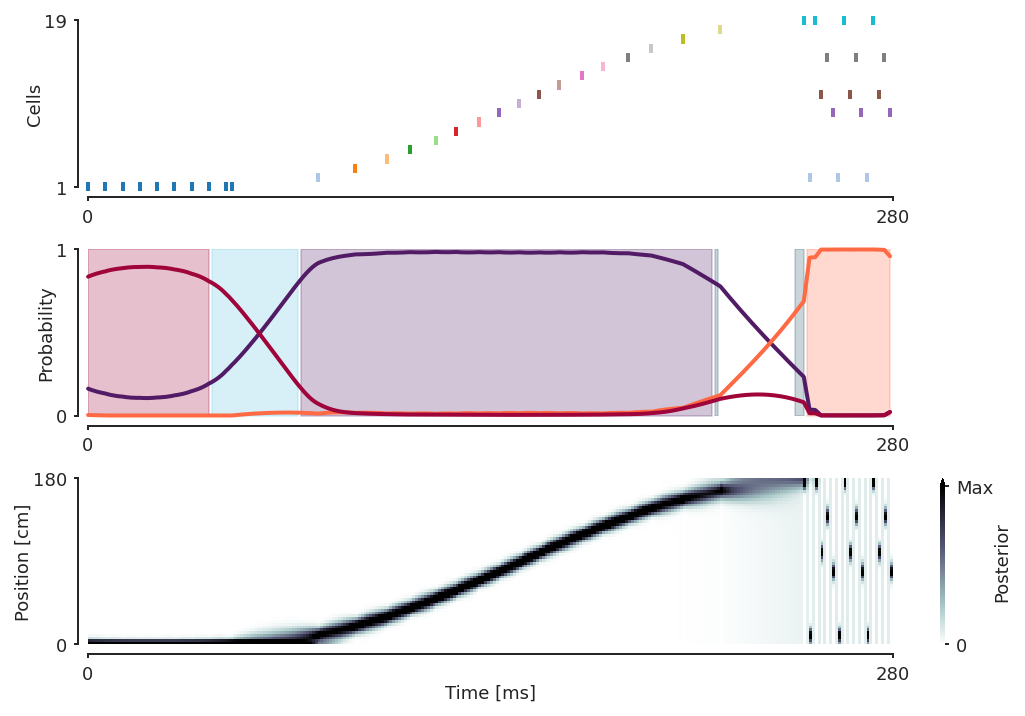

In [451]:
from src.sorted_spikes_simulation import (
    make_hover_continuous_fragmented_replay,
    SAMPLING_FREQUENCY,
)
from src.parameters import STATE_ORDER

replay_time, test_spikes = make_hover_continuous_fragmented_replay()
replay_time *= SAMPLING_FREQUENCY
results = classifier.predict(test_spikes, time=replay_time).assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

fig, axes = plt.subplots(
    3, 1, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

plot_spikes(test_spikes, replay_time, ax=axes[0])
axes[0].set_title("")
axes[0].set_xlabel("")
plot_probabilities(results, ax=axes[1])
axes[1].set_title("")
axes[1].set_xlabel("")
plot_posterior(classifier, results, linear_distance, ax=axes[2])
axes[2].set_title("")
sns.despine(offset=5)

results

In [477]:
np.nonzero(test_spikes)

(array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  50,  80,  93, 104,
        112, 121, 128, 136, 143, 150, 157, 164, 172, 179, 188, 196, 207,
        220, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271,
        273, 275, 277, 279]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,
         8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  1, 18, 10, 14,  8,  1,
        18, 10, 14,  8,  1, 18, 10, 14,  8]))

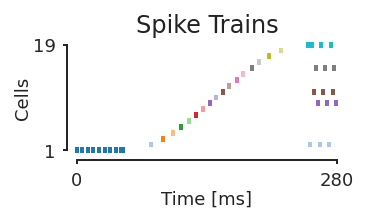

In [452]:
fig, ax = plt.subplots(figsize=(TWO_COLUMN / 3, PAGE_HEIGHT / 10))
plot_spikes(test_spikes, replay_time, ax=ax)
save_figure(os.path.join("Figure1", "figure1_spike_train"))

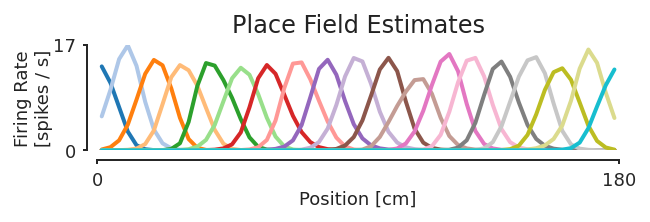

In [453]:
fig, ax = plt.subplots(figsize=(2 * TWO_COLUMN / 3, PAGE_HEIGHT / 10))
plot_place_field_estimates(classifier, ax=ax)
save_figure(os.path.join("Figure1", "figure1_place_field_estimates"))

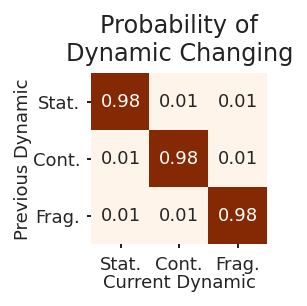

In [454]:
state_names = ["Stat.", "Cont.", "Frag."]
fig, ax = plt.subplots(figsize=(ONE_COLUMN * 0.45, ONE_COLUMN * 0.45))
m = sns.heatmap(
    pd.DataFrame(
        classifier.discrete_state_transition_, index=state_names, columns=state_names
    ),
    annot=True,
    cmap="Oranges",
    ax=ax,
    cbar=False,
    annot_kws=dict(fontsize=9),
    cbar_kws=dict(label="Probability", ticks=[0, 1], orientation="horizontal"),
    vmin=0.0,
    vmax=1.0,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.ylabel("Previous Dynamic")
plt.xlabel("Current Dynamic")
plt.title("Probability of\nDynamic Changing", fontsize=12)
save_figure(os.path.join("Figure1", "figure1_discrete_state_transition"))

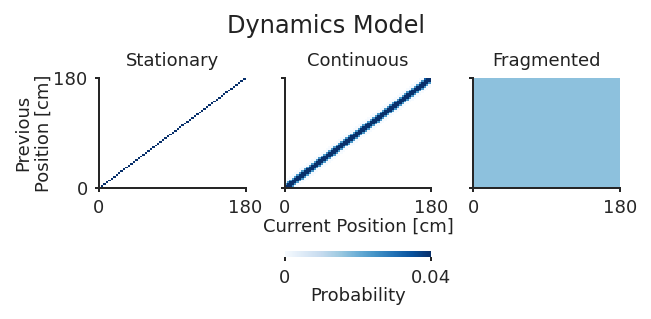

In [455]:
plot_state_transition(classifier)
save_figure(os.path.join("Figure1", "figure1_continuous_transition_matrix"))

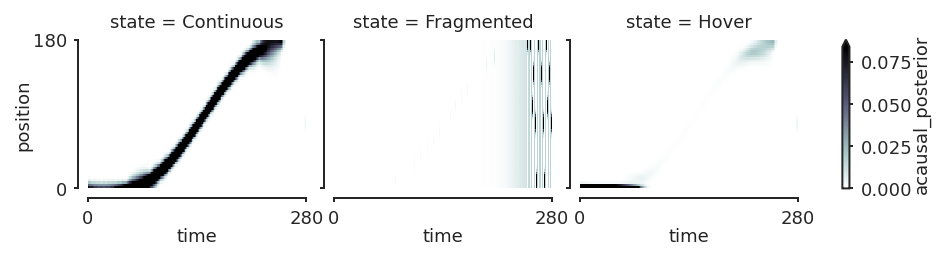

In [458]:
plot_posteriors(results, linear_distance)
save_figure(os.path.join("Figure1", "figure1_posterior"))

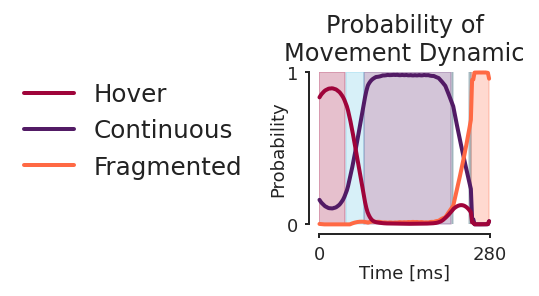

In [459]:
fig, axes = plt.subplots(
    1,
    2,
    gridspec_kw={"width_ratios": [1, 5]},
    figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 5),
    constrained_layout=True,
)
plot_probabilities(results, ax=axes[1])
# ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.05))
h, l = axes[1].get_legend_handles_labels()
l = [l[-1], *l[:2]]
h = [h[-1], *h[:2]]
axes[0].legend(h, l, loc="upper center", borderaxespad=0.0, frameon=False)
axes[0].axis("off")

save_figure(os.path.join("Figure1", "figure1_probability_of_movement_dynamic"))

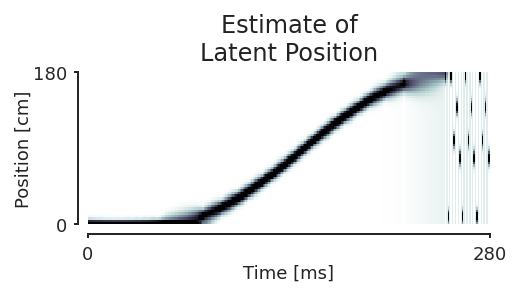

In [463]:
fig, ax = plt.subplots(
    constrained_layout=True, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 5)
)
plot_posterior(classifier, results, linear_distance, ax=ax)
save_figure(os.path.join("Figure1", "figure1_posterior_summed_over_state"))

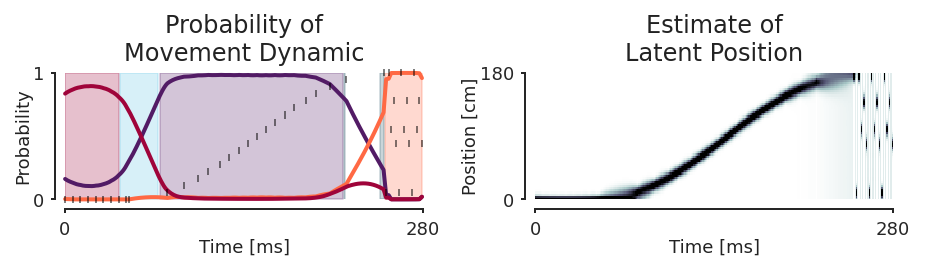

In [470]:
fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COLUMN * 0.9, PAGE_HEIGHT / 5.5), constrained_layout=True
)

plot_probabilities(results, ax=axes[0])
plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=axes[1],
    cbar_orientation="vertical",
    cbar_aspect=50,
)
plot_spikes2(test_spikes, replay_time, ax=axes[0].twinx())

save_figure(os.path.join("Figure1", "figure1_prob_posterior"))

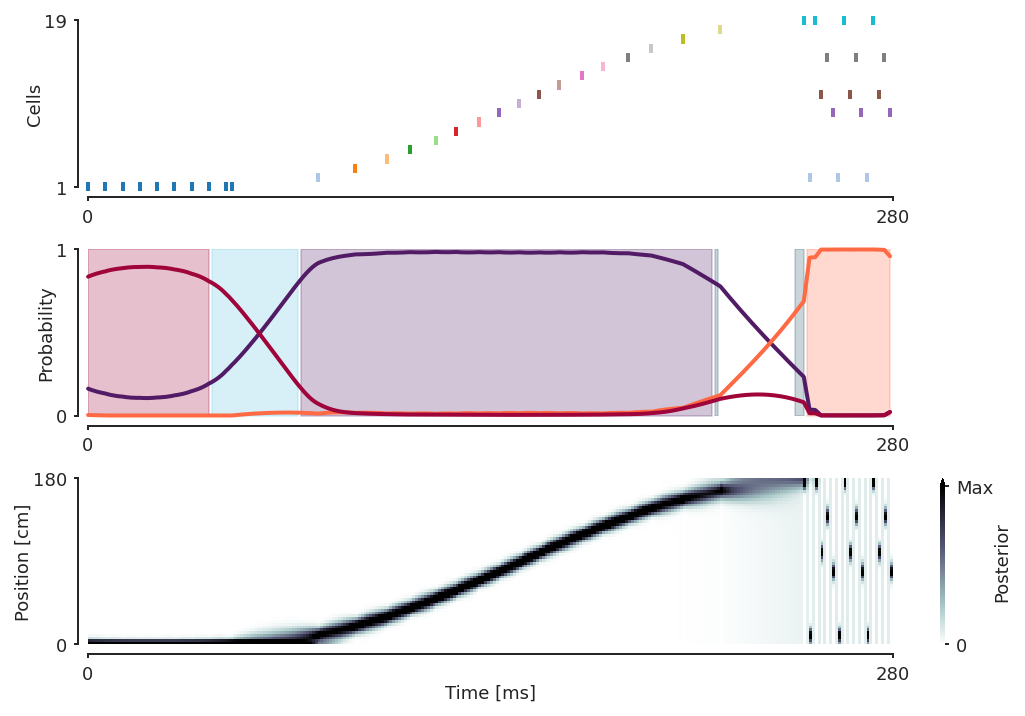

In [441]:
fig, axes = plt.subplots(
    3, 1, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

plot_spikes(test_spikes, replay_time, ax=axes[0])
axes[0].set_title("")
axes[0].set_xlabel("")
plot_probabilities(results, ax=axes[1])
axes[1].set_title("")
axes[1].set_xlabel("")
plot_posterior(classifier, results, linear_distance, ax=axes[2])
axes[2].set_title("")
sns.despine(offset=5)

save_figure(os.path.join("Figure1", "figure1_spikes_prob_posterior"))

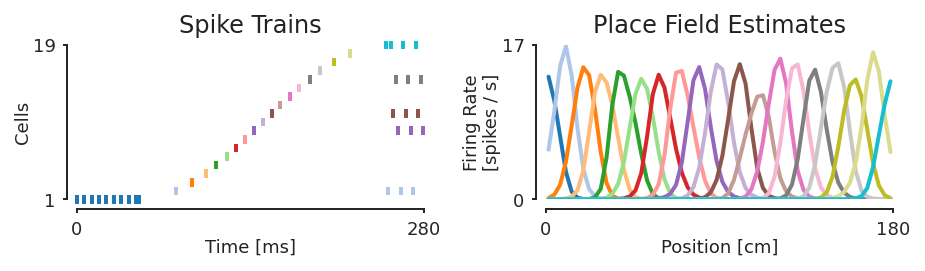

In [471]:
fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COLUMN * 0.9, PAGE_HEIGHT / 5.5), constrained_layout=True,
)
plot_spikes(test_spikes, replay_time, ax=axes[0])
plot_place_field_estimates(classifier, ax=axes[1])
save_figure(os.path.join("Figure1", "figure1_spikes_place_field"))

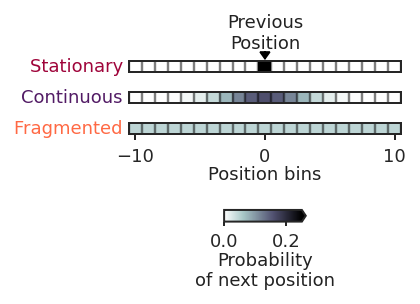

In [443]:
from scipy.stats import multivariate_normal

vmax = 0.4
fig, axes = plt.subplots(
    3, 1, figsize=(ONE_COLUMN * 0.8, 2.0), sharey=True, constrained_layout=True,
)

states = ["Stationary", "Continuous", "Fragmented"]
bins = np.arange(-10.5, 11.5, 1)
bin_centers = bins[:-1] + np.diff(bins) / 2
transition_slice = {
    "Stationary": np.eye(1, len(bin_centers), k=len(bin_centers) // 2).squeeze(),
    "Continuous": multivariate_normal(cov=6).pdf(bin_centers),
    "Fragmented": np.ones_like(bin_centers) / len(bin_centers),
}

x, y = np.meshgrid(bins, [0, 1])

for (ax, name) in zip(axes, states):
    h = ax.pcolormesh(
        x, y, transition_slice[name][np.newaxis, :], cmap="bone_r", vmin=0.0, vmax=0.25
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for b in bins:
        ax.axvline(b, color="black", alpha=0.5)
    state = name if name != "Stationary" else "Hover"
    ax.set_ylabel(
        name + " ",
        fontsize=9,
        rotation=0,
        ha="right",
        va="center",
        color=STATE_COLORS[state],
    )
    ax.tick_params(width=1.0, length=3.0)
    ax.set_ylim((0, 1))
axes[-1].set_xticks([-10, 0, 10])
axes[-1].set_xlabel("Position bins")
axes[0].arrow(
    x=0,
    y=1.20,
    dx=0.0,
    dy=-0.015,
    color="black",
    clip_on=False,
    head_width=0.75,
    head_length=0.6,
    length_includes_head=True,
)
axes[0].text(0, 1.75, "Previous\nPosition", va="bottom", ha="center", fontsize=9)
plt.colorbar(
    h,
    orientation="horizontal",
    shrink=0.3,
    extend="max",
    aspect=5.0,
    label="Probability\nof next position",
    pad=0.2,
    ticks=[0.0, 0.2],
)

save_figure(os.path.join("Figure1", "figure1_continuous_transition_slice"))

## Classification of Speeds

In [5]:
from src.sorted_spikes_simulation import make_constant_velocity_replay
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)
from replay_trajectory_classification import SortedSpikesClassifier
from src.sorted_spikes_simulation import make_simulated_run_data

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

continuous_transition_types = [
    ["random_walk", "uniform", "identity"],  # noqa
    ["uniform", "uniform", "uniform"],  # noqa
    ["random_walk", "uniform", "identity"],
]  # noqa


classifier2 = SortedSpikesClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=0.9999,
    spike_model_penalty=spike_model_penalty,
    knot_spacing=knot_spacing,
).fit(linear_distance, spikes)

classifier2

SortedSpikesClassifier(discrete_transition_diag=0.9999, knot_spacing=5,
                       movement_var=6.0, place_bin_size=3.0, replay_speed=1,
                       spike_model_penalty=0.5)

In [6]:
def get_constant_velocity_stats(classifier, actual_speed=1000):
    replay_time, test_spikes = make_constant_velocity_replay(replay_speed=actual_speed)

    results = classifier.predict(test_spikes, time=replay_time).assign_coords(
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
    )

    return results.acausal_posterior.sum("position").mean("time")

In [7]:
from dask.distributed import Client

client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:38335 Dashboard: http://127.0.0.1:34049/status,Cluster Workers: 16 Cores: 64 Memory: 1.62 TB


In [8]:
from tqdm.autonotebook import tqdm
import xarray as xr
import pandas as pd

speeds = np.arange(0.5, 10_000.5, 0.5)

probabilities = xr.concat(
    [
        get_constant_velocity_stats(classifier2, actual_speed=speed)
        for speed in tqdm(speeds)
    ],
    dim=pd.Index(speeds, name="speed"),
)

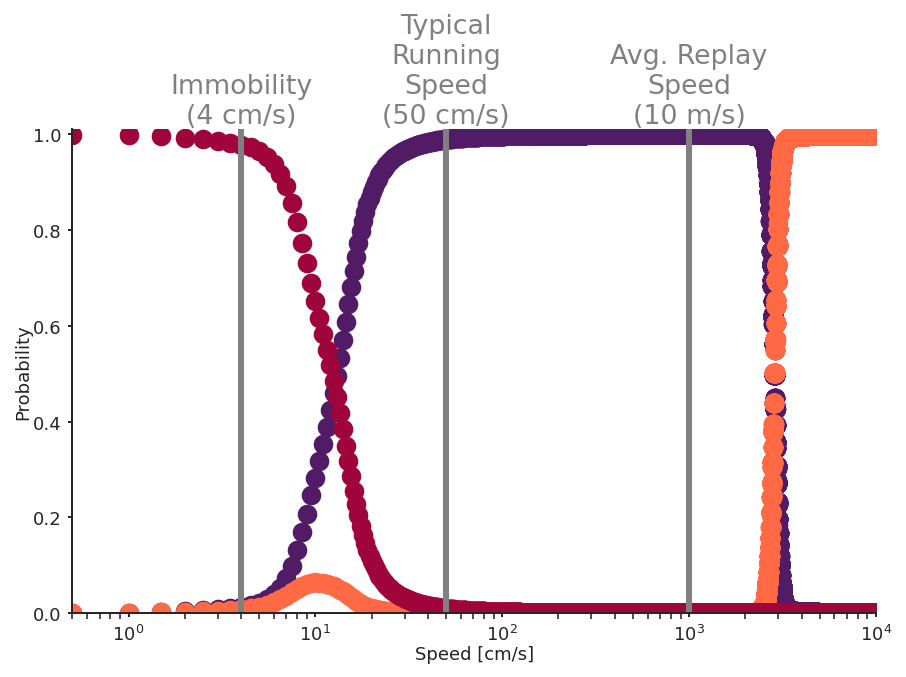

In [9]:
fig, ax = plt.subplots()

for state, prob in zip(probabilities.state.values, probabilities.values.T):
    ax.scatter(speeds, prob, linewidth=5, label=state, color=STATE_COLORS[state])

ax.axvline(4, color="grey", linewidth=3, linestyle="-")
ax.text(4, 1.01, "Immobility\n(4 cm/s)", va="bottom", ha="center", color="grey")

ax.axvline(50, color="grey", linewidth=3, linestyle="-")
ax.text(
    50,
    1.01,
    "Typical\nRunning\nSpeed\n(50 cm/s)",
    va="bottom",
    ha="center",
    color="grey",
)

ax.axvline(1000, color="grey", linewidth=3, linestyle="-")
ax.text(
    1000, 1.01, "Avg. Replay\nSpeed\n(10 m/s)", va="bottom", ha="center", color="grey"
)

ax.set_xlabel("Speed [cm/s]")

ax.set_ylabel("Probability")
ax.set_ylim((0, 1.01))

plt.xscale("log")
ax.set_xlim((speeds.min(), speeds.max()))
sns.despine()

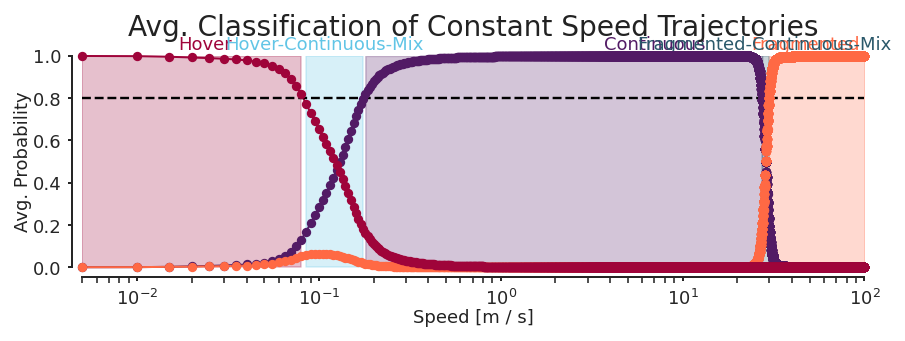

In [474]:
from src.parameters import PROBABILITY_THRESHOLD

CM_TO_M = 1 / 100


def plot_classification_of_speeds(probabilities, is_classified, ax=None):
    if ax is None:
        ax = plt.gca()

    for state, prob in zip(probabilities.state.values, probabilities.values.T):
        ax.plot(
            probabilities.speed * CM_TO_M,
            prob,
            linewidth=1,
            label=state,
            color=STATE_COLORS[state],
            clip_on=False,
        )
        ax.scatter(
            probabilities.speed * CM_TO_M,
            prob,
            color=STATE_COLORS[state],
            zorder=100,
            s=15,
            clip_on=False,
            rasterized=True,
        )

    for state, is_class in zip(is_classified.state.values, is_classified.values.T):
        ax.fill_between(
            probabilities.speed * CM_TO_M,
            is_class,
            where=is_class.astype(bool),
            alpha=0.25,
            color=STATE_COLORS[state],
            interpolate=False,
        )
        speeds = probabilities.speed[is_class.astype(bool)] * CM_TO_M
        ax.text(
            speeds.min() + (speeds.max() - speeds.min()) / 4,
            1.01,
            state,
            va="bottom",
            ha="center",
            fontsize=9,
            color=STATE_COLORS[state],
        )

    ax.set_ylabel("Avg. Probability")
    ax.set_ylim((0, 1))

    ax.set_xlabel("Speed [m / s]")
    ax.set_xscale("log")
    ax.set_xticks((1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2))
    ax.set_title(
        "Avg. Classification of Constant Speed Trajectories", fontsize=14, pad=10
    )

    ax.set_xlim(
        (probabilities.speed.min() * CM_TO_M, probabilities.speed.max() * CM_TO_M)
    )
    ax.axhline(PROBABILITY_THRESHOLD, color="black", linestyle="--")
    sns.despine(offset=5)


fig, ax = plt.subplots(figsize=(TWO_COLUMN, PAGE_HEIGHT / 5))
plot_classification_of_speeds(probabilities, is_classified, ax=ax)
save_figure(os.path.join("Figure1", "figure1_classification_of_speeds"))

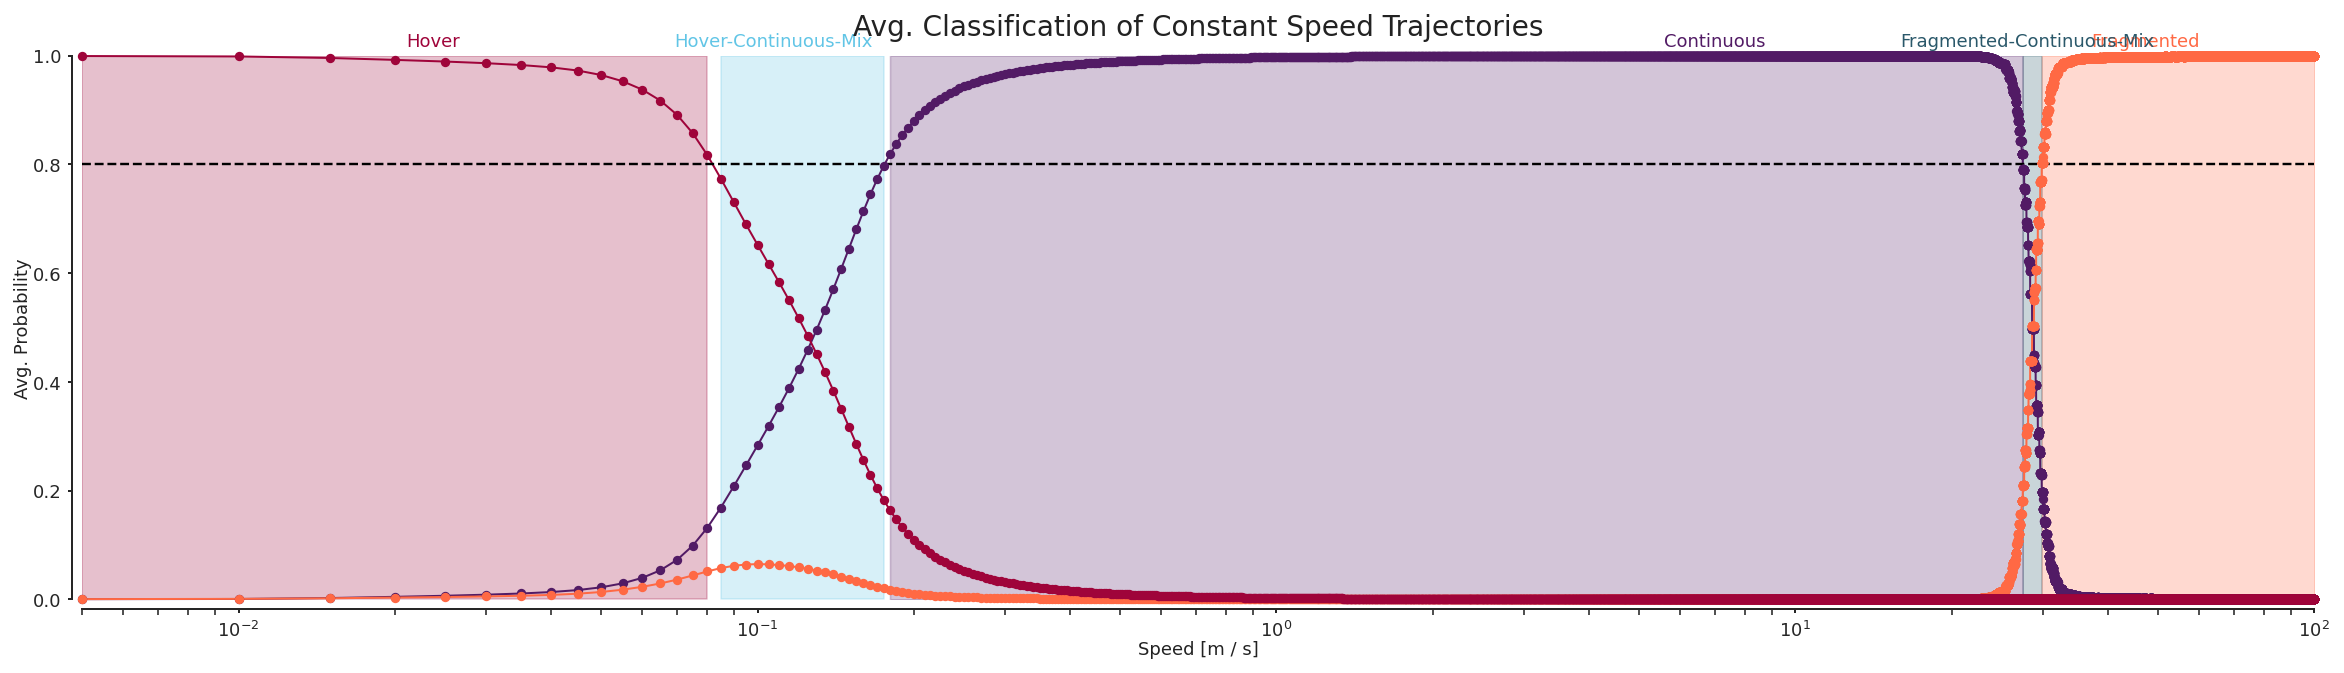

In [475]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_classification_of_speeds(probabilities, is_classified, ax=ax)